# Multi-Class Text Classification with BERT and TensorFlow
* Notebook by Adam Lang
* Date 7/28/2024

# Overview
* In this notebook we will perform multi-class text classification using BERT and TensorFlow.
* The dataset we will use is from an old kaggle competition for Sentiment Classification of Rotten Tomato Movie Reviews.

In [17]:
# install transformers
!pip install transformers

In [2]:
## imports
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import tensorflow as tf
from transformers import BertTokenizer

## Get the data

In [3]:
## we will get data from a raw github file
import requests #making API request to data source
import zipfile #data is in zipfile
from pathlib import Path # creating file/directory paths

# setup path to a data folder
data_path = Path("data/")
train_path = data_path / "train_data"

# If the folder doesn't exist, download it and prepare it...
if train_path.is_dir():
  print(f"{train_path} directory already exists... skipping download")
else:
  print(f"{train_path} does not exist, creating one... ")
  train_path.mkdir(parents=True, exist_ok=True)

# Download
with open(data_path / "train.tsv", "wb") as f:
  ## need 'raw' link address if getting file from github repo
  request = requests.get('https://raw.githubusercontent.com/theartificialguy/NLP-with-Deep-Learning/master/BERT/Multi-Class%20classification%20TF-BERT/train.tsv')
  print("Downloading dataset......")
  f.write(request.content) # write content of request to file



data/train_data does not exist, creating one... 


In [4]:
# upload data
path_data = '/content/data/train.tsv'
df = pd.read_csv(path_data, sep='\t')

#head
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


## Exploratory Data Analysis

In [6]:
## target label - Sentiment
df['Sentiment'].value_counts()

Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64

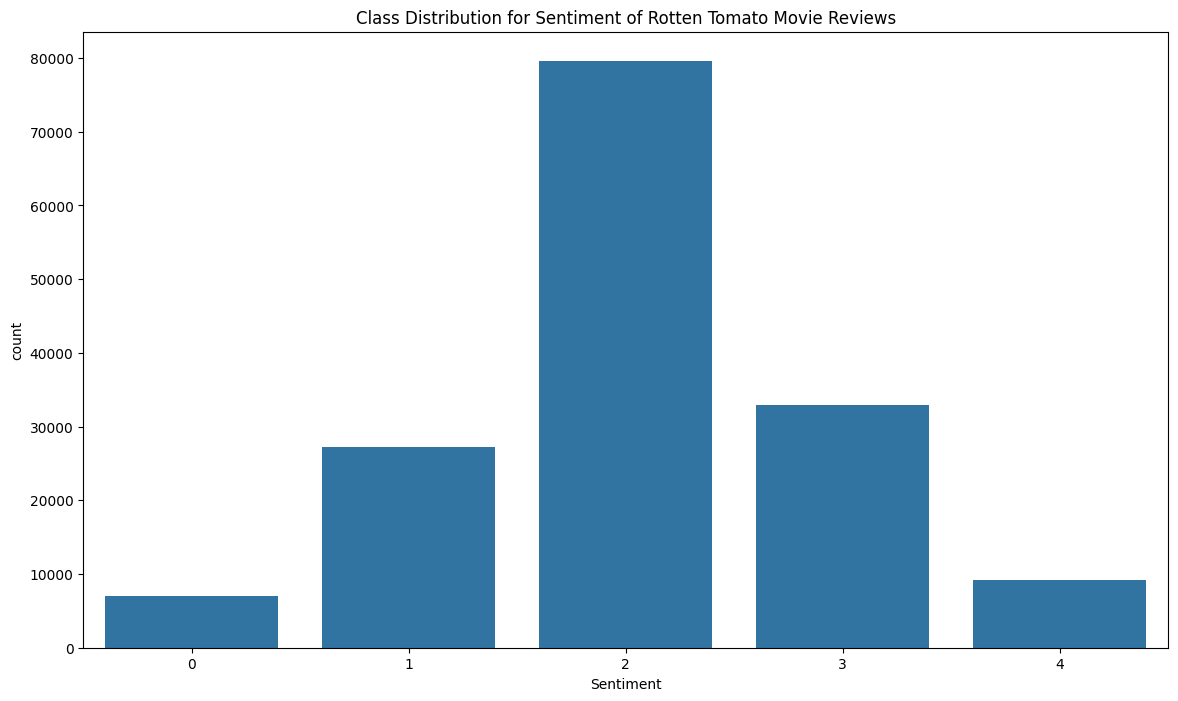

In [7]:
## visualize this
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fig = plt.figure(figsize=(14,8))
sns.countplot(x='Sentiment', data=df).set(title="Class Distribution for Sentiment of Rotten Tomato Movie Reviews")
plt.show();

Summary:
* This is a multi-class classification problem. We can see above the 5 classes are imbalanced. For now we won't balance the classes to see what our results are. We can always go back and use data augmentation techniques.

### Sentiment Class Labels
* This dataset is taken from the original Kaggle Dataset for Sentiment Analysis of Rotten Tomatoes Movie Reviews
   * link: https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data
* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

## Preprocessing

In [8]:
## setup Bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
## testing the tokenizer
df['Phrase'].iloc[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [10]:
## testing the tokenizer
token = tokenizer.encode_plus(
    df['Phrase'].iloc[0],
    max_length=256, #BERT default is 512
    truncation=True,
    padding='max_length',
    add_special_tokens=True, #[CLS], [PAD],[SEP] tokens
    return_tensors='tf'
)

In [11]:
## print result
token

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,   138,  1326,  1104, 13936, 25265, 16913, 15107,  1103,
         8050,  2553,  1115,  1184,  1110,  1363,  1111,  1103, 20398,
         1110,  1145,  1363,  1111,  1103,   176,  9900,   117,  1199,
         1104,  1134,  5411,  1821, 14225,  1133,  3839,  1104,  1134,
         7919,  1106,  1277,  1104,   170,  1642,   119,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

## Input_ids and Attention Masks for BERT model

In [12]:
## create input_ids and attn_masks
X_input_ids = np.zeros((len(df), 256)) #each row has 256 cols -- max len of sentence
X_attn_masks = np.zeros((len(df), 256))

In [13]:
## shape of input_ids
print(f"Shape of input_ids: {X_input_ids.shape}")

Shape of input_ids: (156060, 256)


In [14]:
## shape of attn_masks
print(f"Shape of attn_masks: {X_attn_masks.shape}")

Shape of attn_masks: (156060, 256)


## Generate Training Data

In [15]:
## generate training data
def generate_training_data(df, ids, masks, tokenizer):
  for i, text in tqdm(enumerate(df['Phrase'])):
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )

    ids[i, :] = tokenized_text.input_ids
    masks[i, :] = tokenized_text.attention_mask
  return ids, masks

In [18]:
## generate training data
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [19]:
## lets see input_ids
X_input_ids

array([[  101.,   138.,  1326., ...,     0.,     0.,     0.],
       [  101.,   138.,  1326., ...,     0.,     0.,     0.],
       [  101.,   138.,  1326., ...,     0.,     0.,     0.],
       ...,
       [  101.,   170., 25247., ...,     0.,     0.,     0.],
       [  101.,   170., 25247., ...,     0.,     0.,     0.],
       [  101., 22572., 12148., ...,     0.,     0.,     0.]])

## Labeling
* Now we need the labels for the input_ids

In [20]:
## create labels with Sentiment classes - one-hot-encoding
labels = np.zeros((len(df), 5))

#shape of labels
print(f"Label shape is: {labels.shape}")

Label shape is: (156060, 5)


In [21]:
## one-hot-encoding Sentiment labels
labels[np.arange(len(df)), df['Sentiment'].values] = 1

In [22]:
# label results
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

## Create TensorFlow Dataset
* This maps the input_ids, attn_masks, and labels together.

In [23]:
## TF dataset
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

In [24]:
## example from tf dataset
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [25]:
## creating mapping function for batching
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
  ## returns a dict
  return{
      'input_ids': input_ids,
      'attention_mask': attn_masks,
  }, labels

In [26]:
## apply to dataset
dataset = dataset.map(SentimentDatasetMapFunction)

In [27]:
## view 1 sample
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [28]:
## shuffle and batch training data
## batch size of 16, remove odd remainders
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)

## Feature Engineering
* Set up train and test data

In [29]:
p = 0.8 #80%

## len of df // batch size 16 * 80%
train_size = int((len(df)//16)*p)

In [30]:
## train size is
train_size

7802

In [31]:
## split dataset - train and validation
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## Build Bert Model
* From huggingface

In [32]:
## import tfbertmodel
from transformers import TFBertModel

In [33]:
# instantiate model
bert_model = TFBertModel.from_pretrained('bert-base-cased')

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model Layers
* input_ids
* attention masks
* embeddings
* intermediate layer
* output layer

In [34]:
## input_ids + attn_masks + embedding layers
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attention_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')


# bert embeddings layer
bert_embeds = bert_model.bert(input_ids, attention_mask=attention_masks)[1] # using pooling layer - can also use activation layer

# intermediate layer - bert embeddings are input
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embeds)

# output layer - intermediate layer is input
# output layer - activation function must be softmax for classification
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer)


## model
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

## Loss function, Optimizer, and Accuracy

In [35]:
## optimizer
optim = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)

## loss function - multi-class classification
loss_fn = tf.keras.losses.CategoricalCrossentropy()

## accuracy
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

## Compile model

In [36]:
model.compile(optimizer=optim,
              loss=loss_fn,
              metrics=[acc])

## Train Model

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1
)

## Saving Model

In [ ]:
model.save('bert_sentiment_model')

## Load Saved Model

In [ ]:
load_model = tf.keras.models.load_model('bert_sentiment_model')

## Testing the Model

In [ ]:
input_text = 'This was a really bad movie, the acting was fake!'

In [ ]:
## tokenize input text
def prep_data(input_text, tokenizer):
  token = tokenizer.encode_plus(
      input_text,
      max_length=256,
      truncation=True,
      padding='max_length',
      add_special_tokens=True,
      return_tensors='tf'
  )
  return {
      'input_ids': tf.cast(token.input_ids, tf.float64),
      'attention_mask': tf.cast(token.attention_mask, tf.float64)
  }

In [ ]:
tokenized_input_text = prep_data(input_text, tokenizer)

In [ ]:
tokenized_input_text

In [ ]:
## feed to model
probs = load_model.predict(tokenized_input_text)

In [ ]:
## probs print
output_index = np.argmax(probs[0]) # gives us the max from raw logits
print(classes[output_index])

In [ ]:
classes = ['Negative', 'A bit negative', 'Neutral', 'A bit positive', 'Positive']